In [ ]:
!pip install qiskit
!pip install pylatexenc

     |████████████████████████████████| 6.4 MB 4.5 MB/s 
     |████████████████████████████████| 18.0 MB 225 kB/s 
     |████████████████████████████████| 238 kB 46.6 MB/s 
     |████████████████████████████████| 200 kB 42.0 MB/s 
     |████████████████████████████████| 53 kB 1.6 MB/s 
     |████████████████████████████████| 1.6 MB 38.3 MB/s 
     |████████████████████████████████| 38.1 MB 1.3 MB/s 
     |████████████████████████████████| 38.2 MB 1.4 MB/s 
     |████████████████████████████████| 943 kB 55.9 MB/s 
     |████████████████████████████████| 49 kB 5.1 MB/s 
     |████████████████████████████████| 49 kB 5.4 MB/s 
     |████████████████████████████████| 3.6 MB 37.6 MB/s 
     |████████████████████████████████| 113 kB 59.8 MB/s 
  Created wheel for qiskit: filename=qiskit-0.34.1-py3-none-any.whl size=11771 sha256=dbb7f799f19f27ed30f97fdd8264512a7105d5bb6e30ba531c45790137eabcff
  Stored in directory: /root/.cache/pip/wheels/79/b1/3f/8cdfd5543a84705e4bd16e081f2362b9b3bfd9898d2e2d

# 1 Introduction
## 1-1 Quantum Simulation
One of the leading uses for quantum computers will be to simulate quantum systems such as molecules or engineered materials. Actually executing a quantum simulation on a current quantum computer, however, can be difficult and error prone. Your objective for this Open Science Prize is to significantly improve the state-of-the-art for quantum simulation (details in Section 2).

The quantum system you will simulate is a quantum spin-1/2 model, where each qubit represents a quantum spin-1/2 particle in a 1D chain. Quantum spin models have some amazing properties and uses. Computationally speaking, certain optimization problems can be mapped to spin models and hence minimized on a quantum computer. Physically speaking, spin models show a variety of quantum behavior such as large entangled states, quantum phases of matter, quantum many-body affects, and many other open questions in physics research.

There are many different spin models, but we will focus on the $XXX$ Heisenberg spin model. Though it is not as well known as the transverse-field Ising model, the $XXX$ Heisenberg model is of practical and theoretical interest. It can also be difficult to simulate, which is where you come in.

The notebook is organized as follows: 1) Section 1 (labeled 1-X) provides you with brief introductions to the $XXX$ Heisenberg model, time evolving a Hamiltonian, and decomposing a time evolution operator into gates for a quantum computer to execute. 2) Section 2 (labeled 2-X) outlines the specific requirements and boundaries associated with completing and competing in the Open Science Prize. Continuing from Section 1, the notebook showns an example solution.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})  # enlarge matplotlib fonts

import qiskit

# Import qubit states Zero (|0>) and One (|1>), and Pauli operators (X, Y, Z)
from qiskit.opflow import Zero, One, I, X, Y, Z
import math
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Returns the matrix representation of the XXX Heisenberg model for 3 spin-1/2 particles in a line
def H_heis3():
    # Interactions (I is the identity matrix; X, Y, and Z are Pauli matricies; ^ is a tensor product)
    XXs = (I^X^X) + (X^X^I)
    YYs = (I^Y^Y) + (Y^Y^I)
    ZZs = (I^Z^Z) + (Z^Z^I)
    
    # Sum interactions
    H = XXs + YYs + ZZs
    
    # Return Hamiltonian
    return H

In [ ]:
# Returns the matrix representation of U_heis3(t) for a given time t assuming an XXX Heisenberg Hamiltonian for 3 spins-1/2 particles in a line
def U_heis3(t):
    # Compute XXX Hamiltonian for 3 spins in a line
    H = H_heis3()
    
    # Return the exponential of -i multipled by time t multipled by the 3 spin XXX Heisenberg Hamilonian 
    return (t * H).exp_i()

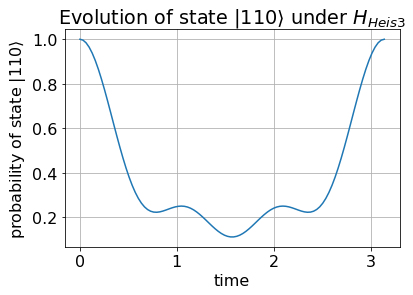

In [ ]:
# Define array of time points
ts = np.linspace(0, np.pi, 100)

# Define initial state |110>
initial_state = One^One^Zero

# Compute probability of remaining in |110> state over the array of time points
 # ~initial_state gives the bra of the initial state (<110|)
 # @ is short hand for matrix multiplication
 # U_heis3(t) is the unitary time evolution at time t
 # t needs to be wrapped with float(t) to avoid a bug
 # (...).eval() returns the inner product <110|U_heis3(t)|110>
 #  np.abs(...)**2 is the modulus squared of the innner product which is the expectation value, or probability, of remaining in |110>
probs_110 = [np.abs((~initial_state @ U_heis3(float(t)) @ initial_state).eval())**2 for t in ts]

# Plot evolution of |110>
plt.plot(ts, probs_110)
plt.xlabel('time')
plt.ylabel(r'probability of state $|110\rangle$')
plt.title(r'Evolution of state $|110\rangle$ under $H_{Heis3}$')
plt.grid()
plt.show()

In [ ]:
# Importing standard Qiskit modules
from qiskit import QuantumCircuit, QuantumRegister, IBMQ, execute, transpile
from qiskit.providers.aer import QasmSimulator
from qiskit.tools.monitor import job_monitor
from qiskit.circuit import Parameter

# Import state tomography modules
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.quantum_info import state_fidelity

from qiskit.ignis.verification.tomography import process_tomography_circuits, ProcessTomographyFitter

# suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# load IBMQ Account data
IBMQ.save_account('',overwrite=True )
IBMQ.load_account()

# IBMQ.save_account(TOKEN)  # replace TOKEN with your API token string (https://quantum-computing.ibm.com/lab/docs/iql/manage/account/ibmq)
#provider = IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [ ]:
#provider = IBMQ.get_provider(hub='ibm-q-research-2', group='iowa-state-uni-1', project='main')
provider = IBMQ.get_provider(hub='ibm-q-community', group='ibmquantumawards', project='open-science-22')
jakarta = provider.get_backend('ibmq_jakarta')

In [ ]:
# Simulated backend based on ibmq_jakarta's device noise profile
sim_noisy_jakarta = QasmSimulator.from_backend(provider.get_backend('ibmq_jakarta'))

# Noiseless simulated backend
sim = QasmSimulator()

In [ ]:
# Parameterize variable t to be evaluated at t=pi later
t = Parameter('t')

In [ ]:
# Build a subcircuit for XX(t) two-qubit gate
XX_qr = QuantumRegister(2)
XX_qc = QuantumCircuit(XX_qr, name='XX')

XX_qc.ry(np.pi/2,[0,1])
XX_qc.cnot(0,1)
XX_qc.rz(2 * t, 1)
XX_qc.cnot(0,1)
XX_qc.ry(-np.pi/2,[0,1])

# Convert custom quantum circuit into a gate
XX = XX_qc.to_instruction()

In [ ]:
# Build a subcircuit for YY(t) two-qubit gate
YY_qr = QuantumRegister(2)
YY_qc = QuantumCircuit(YY_qr, name='YY')

YY_qc.rx(np.pi/2,[0,1])
YY_qc.cnot(0,1)
YY_qc.rz(2 * t, 1)
YY_qc.cnot(0,1)
YY_qc.rx(-np.pi/2,[0,1])

# Convert custom quantum circuit into a gate
YY = YY_qc.to_instruction()

In [ ]:
# Build a subcircuit for ZZ(t) two-qubit gate
ZZ_qr = QuantumRegister(2)
ZZ_qc = QuantumCircuit(ZZ_qr, name='ZZ')

ZZ_qc.cnot(0,1)
ZZ_qc.rz(2 * t, 1)
ZZ_qc.cnot(0,1)

# Convert custom quantum circuit into a gate
ZZ = ZZ_qc.to_instruction()

In [ ]:
heis_qr = QuantumRegister(2)
heis_qc = QuantumCircuit(heis_qr, name='heis')

heis_qc.rz(-np.pi/2,1)
heis_qc.cnot(1,0)
heis_qc.rz(np.pi/2-2 * t, 0)
heis_qc.ry(-np.pi/2+2 * t, 1)
heis_qc.cnot(0,1)
heis_qc.ry(np.pi/2-2 * t, 1)
heis_qc.cnot(1,0)
heis_qc.rz(np.pi/2,1)

# Convert custom quantum circuit into a gate
heis = heis_qc.to_instruction()

In [ ]:
# Combine subcircuits into a single multiqubit gate representing a single trotter step
num_qubits = 3

Trot_qr = QuantumRegister(num_qubits)
Trot_qc = QuantumCircuit(Trot_qr, name='Trot')

for i in range(0, num_qubits - 1):
    Trot_qc.append(heis, [Trot_qr[i], Trot_qr[i+1]])
    #Trot_qc.append(ZZ, [Trot_qr[i], Trot_qr[i+1]])
    #Trot_qc.append(YY, [Trot_qr[i], Trot_qr[i+1]])
    #Trot_qc.append(XX, [Trot_qr[i], Trot_qr[i+1]])

# Convert custom quantum circuit into a gate
Trot_gate = Trot_qc.to_instruction()

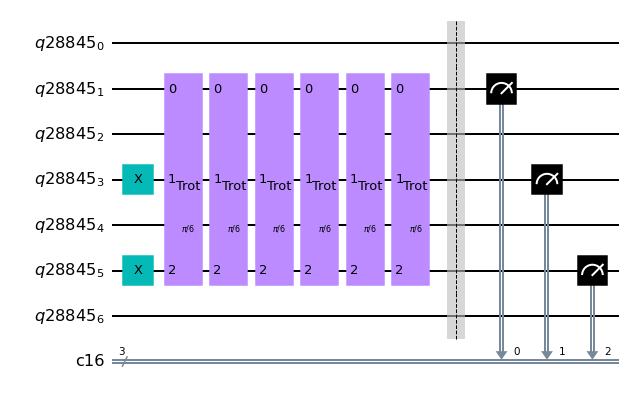

In [ ]:
# The final time of the state evolution
target_time = np.pi#+0.1

# Number of trotter steps
trotter_steps = 6 ### CAN BE >= 4

# Initialize quantum circuit for 3 qubits
qr = QuantumRegister(7)
qc = QuantumCircuit(qr)

# Prepare initial state (remember we are only evolving 3 of the 7 qubits on jakarta qubits (q_5, q_3, q_1) corresponding to the state |110>)
qc.x([3,5])  # DO NOT MODIFY (|q_5,q_3,q_1> = |110>)

# Simulate time evolution under H_heis3 Hamiltonian
for _ in range(trotter_steps):
    qc.append(Trot_gate, [qr[1], qr[3], qr[5]])

# Evaluate simulation at target_time (t=pi) meaning each trotter step evolves pi/trotter_steps in time
qc = qc.bind_parameters({t: target_time/trotter_steps})

# Generate state tomography circuits to evaluate fidelity of simulation
st_qcs = state_tomography_circuits(qc, [qr[1], qr[3], qr[5]])

# Display circuit for confirmation
# st_qcs[-1].decompose().draw()  # view decomposition of trotter gates
st_qcs[-1].draw('mpl')  # only view trotter gates

In [ ]:
def DD_circuit(circuit, backend, qubits_list, initial_layout = None, name=False):

  if initial_layout:

    circuit = transpile(circuit, backend, optimization_level=0, scheduling_method='asap',initial_layout =init_layout)

  else:

    circuit = transpile(circuit, backend, optimization_level=0, scheduling_method='asap')

  if name:

    DD_cir = QuantumCircuit(*circuit.qregs,*circuit.cregs,name=circuit.name)

  else:

    DD_cir = QuantumCircuit(*circuit.qregs,*circuit.cregs)
  
  for operation in circuit[:]:

    if type(operation[0])==qiskit.circuit.delay.Delay:

      if  operation[0].duration >= 400:

        q_index = operation[1][0].index

        if q_index in qubits_list:

          t=(operation[0].duration-320)//4

          t = math.ceil((t)/16)*16

          DD_cir.delay(t,[q_index],'dt')

          DD_cir.x(q_index)

          DD_cir.delay(2*t,[q_index],'dt')

          DD_cir.z(q_index)

          DD_cir.x(q_index)

          DD_cir.z(q_index)

        else:

          DD_cir.data.append(operation)

      else:
        
        DD_cir.data.append(operation)

    else:

      DD_cir.data.append(operation)

  return DD_cir

In [ ]:
from qiskit import *

In [ ]:
from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter

In [ ]:
qubits_list = [1,3,5]

cirs=[]

for i in range(len(st_qcs)):

    cir=DD_circuit(st_qcs[i], jakarta, qubits_list, name=True )

    cir = transpile(cir, jakarta, optimization_level=0, scheduling_method='asap')

    cirs.append(cir)

In [ ]:
qubits_list = [1,3,5]

shots=8192

qr = QuantumRegister(len(qubits_list),'q')

meas_calibs, state_labels = complete_meas_cal(qr=qr, circlabel='mcal')

In [ ]:

init_layout = {}

for i,j in enumerate(qubits_list):

    init_layout[qr[i]] = j

cal_results = execute(meas_calibs, jakarta, shots=shots, initial_layout=init_layout)

print('Job ID', cal_results.job_id())

Job ID 6201d91f0346cd21e4149c07


In [ ]:
shots = 32000 #8192
reps = 4
backend = sim_noisy_jakarta
# reps = 8
backend = jakarta

jobs = []
for _ in range(reps):
    # execute
    #job = execute(cirs, backend, shots=shots)
    job = execute(st_qcs, backend, shots=shots)
    print('Job ID', job.job_id())
    jobs.append(job)

Job ID 6201d922620089f3ccdde520
Job ID 6201d927f7a5d858ce0b3fc2
Job ID 6201d92bf7a5d842c90b3fc3
Job ID 6201d930f7a5d89fc80b3fc4


In [ ]:
for job in jobs:
    job_monitor(job)
    try:
        if job.error_message() is not None:
            print(job.error_message())
    except:
        pass

Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


In [ ]:
#cal_results=backend.retrieve_job('61aac3f06a8ec04639199bcd')

#cal_results=backend.retrieve_job('61a67121727f7d0a25ddb2fe')

In [ ]:
meas_fitter = CompleteMeasFitter(cal_results.result(), state_labels)

meas_filter = meas_fitter.filter

In [ ]:
# Compute the state tomography based on the st_qcs quantum circuits and the results from those ciricuits
def state_tomo(result, st_qcs):
    # The expected final state; necessary to determine state tomography fidelity
    target_state = (One^One^Zero).to_matrix()  # DO NOT MODIFY (|q_5,q_3,q_1> = |110>)
    # Fit state tomography results

    mit_result = meas_fitter.filter.apply(result)

    tomo_fitter = StateTomographyFitter(mit_result, st_qcs)

    rho_fit = tomo_fitter.fit(method='lstsq')
    # Compute fidelity
    fid = state_fidelity(rho_fit, target_state)
    return fid

# Compute tomography fidelities for each repetition

fids = []
for job in jobs:
    fid = state_tomo(job.result(), st_qcs)
    fids.append(fid)
    
print('state tomography fidelity = {:.4f} \u00B1 {:.4f}'.format(np.mean(fids), np.std(fids)))

state tomography fidelity = 0.4426 ± 0.0255


In [ ]:
import qiskit.tools.jupyter
%qiskit_version_table

In [ ]:
fids

[0.46112449002183814,
 0.4248126774037962,
 0.47346532763382837,
 0.4110893691736049]